# Features

In this document we will explain the different features that you can extract from the displacmenet and velocity traces. 

Let us first download some demo data that we can use as an illustrative example

In [28]:
from pathlib import Path
import matplotlib.pyplot as plt # For plotting
import mps # Package to load data
import mps_motion # Package for motion analysis
import ap_features as apf  # Package for analzying traces
import numpy as np

In [29]:
path = Path("data.npy")
if not path.is_file():
    mps_motion.utils.download_demo_data(path)

In [30]:
data = mps.MPS(path)

And let us compute a velocity and displacement trace. First we create an optical flow object

In [31]:
opt_flow = mps_motion.OpticalFlow(data, flow_algorithm="farneback")

Then we compute the velocity

In [42]:
spacing = 5
V = opt_flow.get_velocities(spacing=spacing)

2023-01-03 20:50:07,118 [97254] INFO     mps_motion.farneback: Get velocities using Farneback's algorithm


[########################################] | 100% Completed | 2.82 sms


2023-01-03 20:50:11,420 [97254] INFO     mps_motion.farneback: Done running Farneback's algorithm


and the mean velocity norm

In [58]:
v_mean_norm = V.norm().mean().compute() * 1000.0  # Multiply by 1000 to convert velocity from um / ms to um / s

And now we estimate the reference frame

In [46]:
reference_frame_index = (
    mps_motion.motion_tracking.estimate_referece_image_from_velocity(
        t=data.time_stamps[:-5],
        v=v_mean_norm,
    )
)
reference_frame = data.time_stamps[reference_frame_index]

And finally compute the displacement

In [47]:
U = opt_flow.get_displacements(reference_frame=reference_frame)

and compute the mean displacement norm

In [48]:
u_mean_norm = U.norm().mean().compute()

Let us now plot the two traces

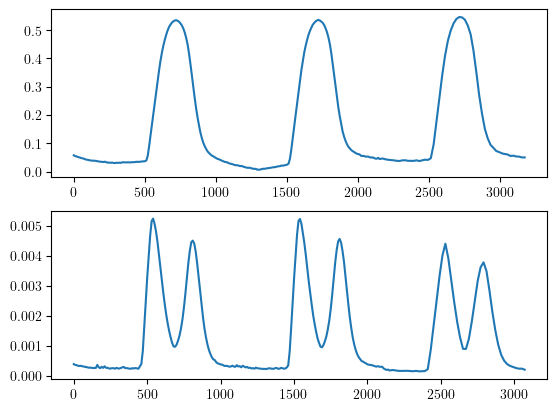

In [49]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(data.time_stamps, u_mean_norm)
ax[1].plot(data.time_stamps[:-5], v_mean_norm)
plt.show()

Let us extract the first beat and plot the different features

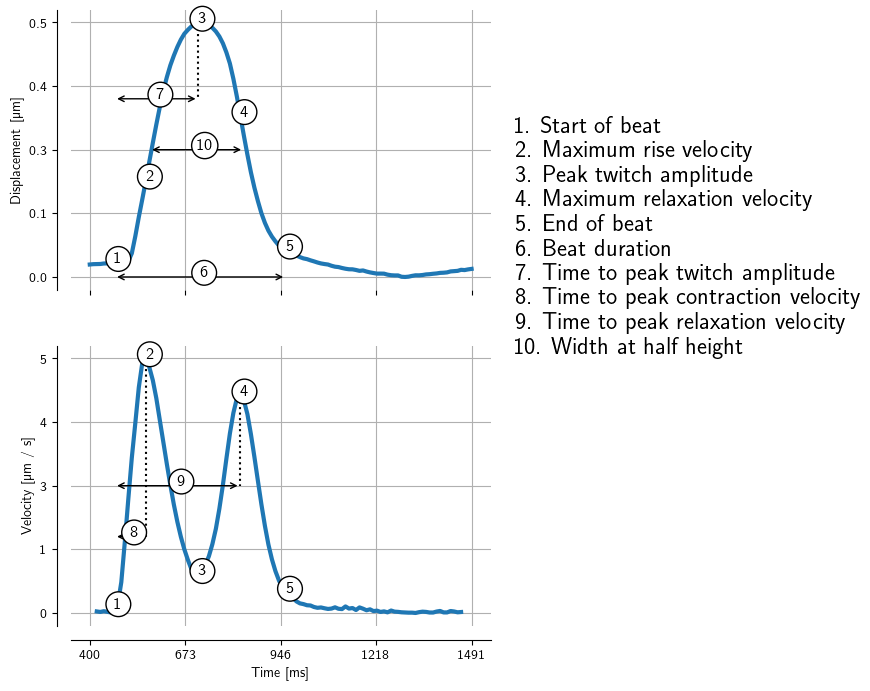

In [59]:
start = 40
end = 150

u = apf.Beats(
    y=u_mean_norm[start:end],
    t=data.time_stamps[start:end],
)
v = apf.Beats(
    y=v_mean_norm[start : end - spacing],
    t=data.time_stamps[start : end - spacing],
)

def normalize(y):
    return (y - np.min(y)) / (np.max(y) - np.min(y))

u_norm = normalize(u.y)
v_norm = normalize(v.y)
time = normalize(u.t)
time_v = time[spacing // 2 :]


spacing = 5
labels = ["1", "2", "3", "4", "5"]
indices_u = [7, 16, 31, 43, 56]
indices_v = [i - spacing // 2 for i in indices]

def arrow_annotate(axi, y, t1, t2, label):
    mid_t = 0.5 * (t1 + t2)
    axi.annotate(
        text="",
        xy=(t1, y),
        xytext=(t2, y),
        arrowprops=dict(arrowstyle="<->"),
    )
    axi.text(
        mid_t,
        y,
        label,
        size="large",
        bbox=dict(boxstyle="circle", fc="w", ec="k"),
    )
    
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(("outward", 10))  # outward by 10 points
        else:
            spine.set_color("none")  # don't draw spine

    # turn off ticks where there is no spine
    if "left" in spines:
        ax.yaxis.set_ticks_position("left")
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if "bottom" in spines:
        ax.xaxis.set_ticks_position("bottom")
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))


ax[0].plot(time, u_norm, linewidth=3)
for ind, label in zip(indices, labels):
    ax[0].text(
        time[ind],
        u_norm[ind],
        label,
        size="large",
        bbox=dict(boxstyle="circle", fc="w", ec="k"),
    )

ax[1].plot(time_v[: len(v_norm)], v_norm, linewidth=3)
for ind, label in zip(indices_v, labels):
    ax[1].text(
        time_v[ind],
        v_norm[ind],
        label,
        size="large",
        bbox=dict(boxstyle="circle", fc="w", ec="k"),
    )
    
# Beat duratiom
arrow_annotate(
    ax[0],
    y=0,
    t1=time[indices[0]],
    t2=time[indices[4]],
    label="6",
)

# Time to peak twich amplitude
ax[0].plot(
    [time[indices[2]], time[indices[2]]],
    [u_norm[indices[2]], 0.7],
    "k:",
)
arrow_annotate(
    ax[0],
    y=0.7,
    t1=time[indices[0]],
    t2=time[indices[2]],
    label="7",
)

# Time to peak contraction
ax[1].plot(
    [time_v[indices_v[1]], time_v[indices_v[1]]],
    [v_norm[indices_v[1]], 0.3],
    "k:",
)
arrow_annotate(
    ax[1],
    y=0.3,
    t1=time_v[indices_v[0]],
    t2=time_v[indices_v[1]],
    label="8",
)

# Time_v to peak relaxation
ax[1].plot(
    [time_v[indices_v[3]], time_v[indices_v[3]]],
    [v_norm[indices_v[3]], 0.5],
    "k:",
)
arrow_annotate(
    ax[1],
    y=0.5,
    t1=time_v[indices_v[0]],
    t2=time_v[indices_v[3]],
    label="9",
)

# Width at half height
(zero_crossings,) = np.where(np.diff(np.sign(u_norm - 0.5)))

arrow_annotate(
    ax[0],
    y=0.5,
    t1=time[zero_crossings[0]],
    t2=time[zero_crossings[1]],
    label="10",
)

adjust_spines(ax[0], ["left"])
adjust_spines(ax[1], ["left", "bottom"])

num_points = 5
points = np.linspace(0, 1, num_points)
u_points = np.linspace(np.min(u.y), np.max(u.y), num_points)
ax[0].set_yticks(points)
ax[0].set_yticklabels([f"{vi:.1f}" for vi in u_points])
v_points = np.linspace(np.min(v.y), np.max(v.y), num_points)
ax[1].set_yticks(points)
ax[1].set_yticklabels([f"{vi:.0f}" for vi in v_points])

t_points = np.linspace(u.t[0], u.t[-1], num_points)
ax[1].set_xticks(points)
ax[1].set_xticklabels([f"{vi:.0f}" for vi in t_points])
ax[1].set_xlabel("Time [ms]")
    
for axi in ax:
    axi.grid()
    
ax[0].set_ylabel("Displacement [\u00B5m]")
ax[1].set_ylabel("Velocity [\u00B5m / s]")

legend = "\n".join(
    [
        "1. Start of beat",
        "2. Maximum rise velocity",
        "3. Peak twitch amplitude",
        "4. Maximum relaxation velocity",
        "5. End of beat",
        "6. Beat duration",
        "7. Time to peak twitch amplitude",
        "8. Time to peak contraction velocity",
        "9. Time to peak relaxation velocity",
        "10. Width at half height",
    ]
)
fig.text(0.68, 0.45, legend, size="xx-large")
fig.subplots_adjust(right=0.65)
plt.show()

In [60]:
for k, v in mps_motion.stats.compute_features(u=u.y, v=v.y, t=u.t).items():
    print(f"{k}: {v[0]}")

Maximum rise velocity: 4.793865867620719
Peak twitch amplitude: 0.46370260811663705
Maximum relaxation velocity: 3.9088881640867603
Beat duration: 1090.8010253906468
Time to peak twitch amplitude: 320.24218750007094
Time to peak contraction velocity: 140.1030273437982
Time to peak relaxation velocity: 410.2900390624882
Width at half height: 259.2571716286242
